In [10]:
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

# https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height).T

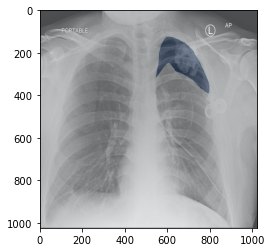

In [11]:
import os
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
file_ImageId_path = []
for root, dir_, files in os.walk("dicom-images-train"):
    for file in files:
        if file.endswith(".dcm"):
            file_ImageId_path.append([os.path.splitext(file)[0], os.path.join(root, file)])
            
df_files = pd.DataFrame(file_ImageId_path, columns=["ImageId", "filepath"])

df_files = pd.DataFrame(file_ImageId_path, columns=["ImageId", "filepath"])
df_files
df_siim = pd.read_csv("train-rle.csv")
df_siim_file = pd.merge(df_siim, df_files, on="ImageId")
case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[1]]
dcm = pydicom.dcmread(case1.filepath.values.tolist()[0])
img = dcm.pixel_array
height, width = img.shape
mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0], width, height)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.3)

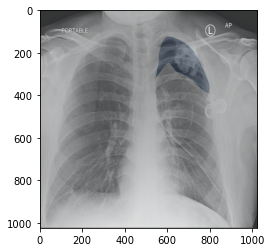

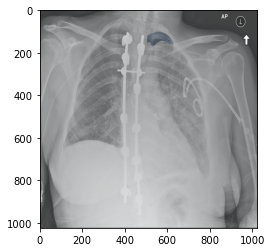

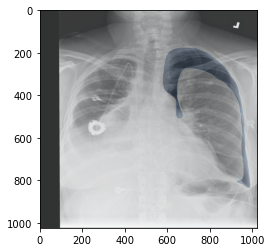

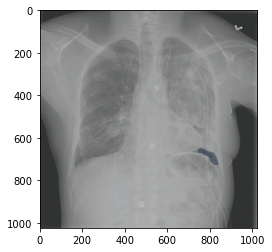

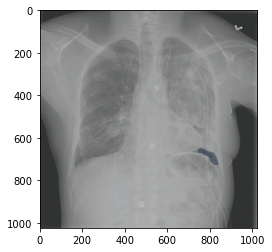

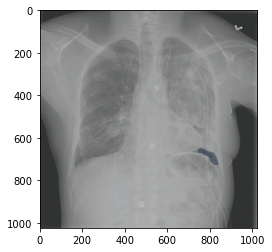

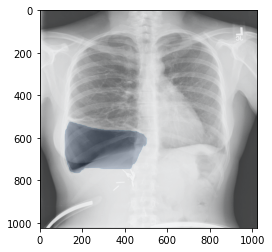

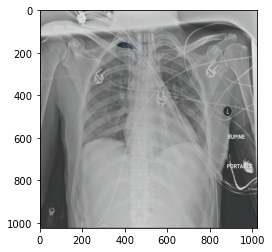

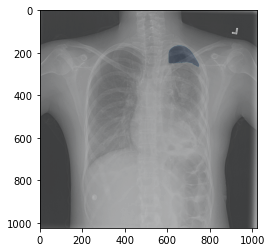

In [12]:
from pydicom import dcmread
from pydicom.data import get_testdata_files

# # mask 加上 .T 
# # https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes
# def rle2mask(rle, width, height):
#     mask= np.zeros(width* height)
#     array = np.asarray([int(x) for x in rle.split()])
#     starts = array[0::2]
#     lengths = array[1::2]

#     current_position = 0
#     for index, start in enumerate(starts):
        
#         current_position += start
#         mask[current_position:current_position+lengths[index]] = 255
        
#         current_position += lengths[index]

#     return mask.reshape(width, height).T

for i in range(30):
    
    case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[i]]
    dcm = dcmread(case1.filepath.values.tolist()[0])
    img = dcm.pixel_array
    height, width = img.shape
    
    
    if not (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        
    
        mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0],  height, width)
        plt.imshow(img, cmap='gray')
        plt.imshow(mask, cmap='Blues', alpha=0.2)
        plt.show()